## CS 5242 Project Bonus, NUS 2020 Semester2

**Group Name: Team 2333**

**Group members:**
- Li Fengzi A0206468Y 
- Xiuping Hua A0206514N
- Shi Haohui A0206537E
- Jonathan Simon Wagner A0152784X

**Project address: https://www.kaggle.com/c/cs5242project/data**

- Data: I3D features, dimension is D=400
- Training videos: P16-P54
- Test videos: P03-P15
- Total 1712 videos
- Ground truth: frame-wise sub-action labels for each video. Dim = Ni*1 (total num of frames in video i, including 'SIL') 
- Splits:4 splits, split1 - test, train on other splits
- 48 different sub-actions including SIL (48 classes)
- 10 breakfast activities
- Each video contain Ni frames, various sub-actions, so various segments, thus various segment labels
- data_feat: I3D features for all training videos, dimension = Ni * D, Ni-frames, D=400
- data_labels: a list of all training labels, a list variable of length = the number of training segment for this video clip, i.e. segment labels, not the frame labels

- load data: template_code.py
- **Predict segments using KMeans clustering**

## 1. Load libraries

In [0]:
%tensorflow_version 1.x
import tensorflow

In [0]:
# Load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# mounted at google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'CS5242'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Update path to import from drive
import sys
sys.path.append('/content/gdrive/My Drive/CS5242')

## 2. Load data

In [0]:
from read_datasetBreakfast import load_data, read_mapping_dict
import os

COMP_PATH = 'content/gdrive/My Drive/CS5242/'

''' 
training to load train set
test to load test set
'''

train_split =  os.path.join(base_dir, 'splits/train.split1.bundle') #Train Split
test_split  =  os.path.join(base_dir, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(base_dir, 'groundTruth/groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(base_dir, 'data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(base_dir, 'splits/mapping_bf.txt')

actions_dict = read_mapping_dict(mapping_loc)

data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = 'training') #Get features and labels
data_feat_test = load_data(test_split, actions_dict, GT_folder, DATA_folder, datatype = 'test') #Get features only

Finish Load the Training data and labels!!!


In [0]:
print('Number of training videos:', len(data_feat), '; Number of training segment labels: ',len(data_labels))

Number of training videos: 1460 ; Number of training segment labels:  1460


In [0]:
# First data_feat shape and number of segment labels
print('I3D feature dimension of the first video: ', data_feat[0].shape)
print('Sub-action segment labels of the first video: ', data_labels[0])

I3D feature dimension of the first video:  torch.Size([544, 400])
Sub-action segment labels of the first video:  [1, 2]


## 3. Predict segments of train data using KMeans clustering and apply max-pooling

In [0]:
from sklearn.cluster import KMeans

data_feat_all = []
for i in range(len(data_feat)):
  data_feat_frame = []
  for frame in data_feat[i]:
    data_feat_frame.append(np.array(frame))

  df = pd.DataFrame({'features': data_feat_frame})
  df = df.rename_axis('index').reset_index()

  # Calculate relative time stamp of each frame
  df['time_stamp'] = df['index']/df.shape[0]  

  # Use KMeans to get segment clusters
  # K is decided by number of labels plus 2 (2 is the number of silence segments)
  np.random.seed(5242)
  kmeans = KMeans(n_clusters=len(data_labels[i])+2, init='k-means++', random_state=5242)
  kmeans.fit(np.array(data_feat_frame))

  df = pd.concat([df, pd.Series(kmeans.labels_, index = df.index)], axis = 1).rename(columns = {0:'cluster'})

  # Calculate the mean time stamp of each cluster
  cluster = list(range(len(data_labels[i])+2))
  mean_time = [df[df.cluster == i].time_stamp.mean() for i in cluster]
  time_order = pd.DataFrame({'cluster':cluster, 'mean_time':mean_time})
  time_order = time_order.sort_values(by=['mean_time']).reset_index()

  # Cut silence segments
  final_cluster = list(time_order.drop(index = [cluster[0],cluster[-1]])['index'])  
  
  # Feature extraction using max-pooling
  data_feat_new = []
  for index in final_cluster:
    segment = np.array(list(df[df.cluster == index]['features']))
    data_feat_new.append(segment.max(axis = 0))

  data_feat_all.append(data_feat_new)

In [0]:
# Find the max number of segments in one video
train_seg = []
for k in data_feat_all:
  train_seg.append(len(k))
print('The max number of segments is :', max(train_seg))

The max number of segments is : 23


In [0]:
# Make each video contain 28 segments through padding
from keras.preprocessing import sequence
from keras.utils import to_categorical
data_feat_pad= sequence.pad_sequences(data_feat_all, maxlen=28, padding='post', truncating='post', value=0.0, dtype='float64')
data_labels_pad = sequence.pad_sequences(data_labels, maxlen=28, padding='post', truncating='post', value=0)
data_labels_pad = [to_categorical(i, 48) for i in data_labels_pad]
data_feat_pad = np.array(data_feat_pad)
data_labels_pad = np.array(data_labels_pad)

In [0]:
# Delete data_feat to save ram
del data_feat

## 4. Prediction of Test dataset and Submission

In [0]:
from keras.layers import Dense, Flatten, Dropout, Bidirectional,TimeDistributed, GRU
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras import backend

###4.1 Build and train models

In [0]:
# Re-build two models and use the whole dataset to train
# Build Bi-Directional GRU model 
seg_class = 48 
bi_gru_model = Sequential()
bi_gru_model.add(Bidirectional(GRU(1024, dropout=0.08, return_sequences=True), merge_mode='concat' ,input_shape= data_feat_pad[0].shape))
bi_gru_model.add(Bidirectional(GRU(1024, dropout=0.08, return_sequences=True), merge_mode='concat')) 
bi_gru_model.add(TimeDistributed(Dense(seg_class, activation='softmax'))) 
bi_gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_gru_model.summary())

# Build Bi-Directional LSTM model 
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(1024, dropout=0.08, return_sequences=True), merge_mode='sum', input_shape=data_feat_pad[0].shape)) 
bi_lstm_model.add(Bidirectional(LSTM(1024, dropout=0.08, return_sequences=True), merge_mode='sum'))
bi_lstm_model.add(TimeDistributed(Dense(seg_class, activation='softmax')))
bi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 28, 2048)          8755200   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 28, 2048)          18880512  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 28, 48)            98352     
Total params: 27,734,064
Trainable params: 27,734,064
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 28, 1024)          11673600  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 28, 1024)          16785408  
_______________

In [0]:
#Use early stopping and learning rate adjustment to avoid overfitting
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
# Train two models and adjust the number of epochs
history_bi_gru = bi_gru_model.fit(data_feat_pad, data_labels_pad, batch_size=400, epochs=200, verbose=0, shuffle=False, callbacks=[earlyStopping, reduce_lr_loss]) 


Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


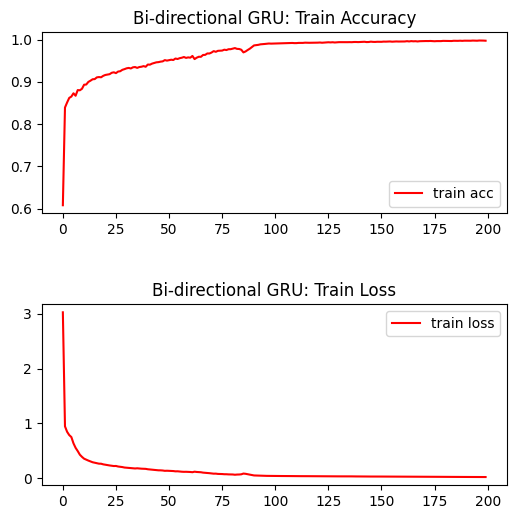

In [0]:
# Plot train and valid loss history of Bi-directional GRU model
loss_gru = history_bi_gru.history['loss']
acc_gru = history_bi_gru.history['accuracy']

epoch_number = range(len(acc_gru))
plt.figure(figsize=(6, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(epoch_number, acc_gru, 'r', label='train acc')
plt.title('Bi-directional GRU: Train Accuracy')
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,2)
plt.plot(epoch_number, loss_gru, 'r', label='train loss')
plt.title('Bi-directional GRU: Train Loss')
plt.legend()

plt.show()

In [0]:
history_bi_lstm = bi_lstm_model.fit(data_feat_pad, data_labels_pad, batch_size=400, epochs=200, verbose=0, shuffle=False, callbacks=[earlyStopping, reduce_lr_loss]) 


Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


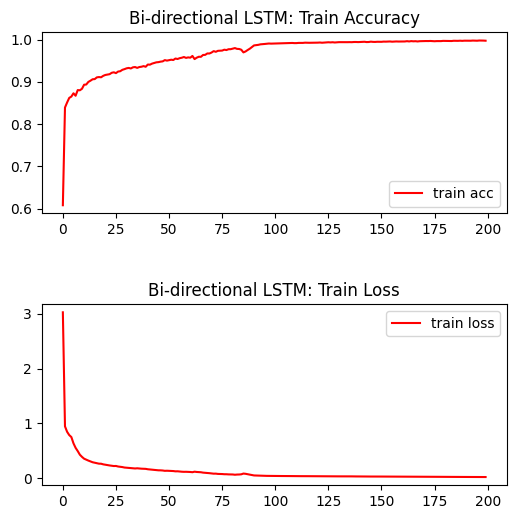

In [0]:
# Plot train and valid loss history of Bi-directional LSTM model
loss_lstm = history_bi_lstm.history['loss']
acc_lstm = history_bi_lstm.history['accuracy']

epoch_number = range(len(acc_lstm))
plt.figure(figsize=(6, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(epoch_number, acc_gru, 'r', label='train acc')
plt.title('Bi-directional LSTM: Train Accuracy')
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,2)
plt.plot(epoch_number, loss_gru, 'r', label='train loss')
plt.title('Bi-directional LSTM: Train Loss')
plt.legend()

plt.show()

###4.2 Pre-processing of Testset

In [0]:
# Get test segments 
def data_seg(file_path):
  data_segment_list = []
  data_segments = [line.split('\n') for line in file_path.readlines()]
  
  for i in range(len(data_segments)):
    data_segment_list.append(data_segments[i][0])
  
  data_seg = [segment_line.split(' ') for segment_line in data_segment_list]
  return data_seg

file_test = open("/content/gdrive/My Drive/CS5242/test_segment.txt", "r")
test_seg = data_seg(file_test)

test_seg_new = []
for i in test_seg:
  seg = []
  for j in i:
    seg.append(int(j))
  test_seg_new.append(seg)
print(test_seg_new[0:5])
print(len(test_seg_new))

[[30, 150, 428, 575, 705], [38, 199, 378, 775], [385, 599, 1382, 4007, 4123], [54, 229, 514, 754, 1024], [483, 548, 703, 853, 2633, 2960, 3310, 3740, 4110, 4200, 4375]]
252


In [0]:
# Test set feature extraction by Max Pooling
from read_datasetBreakfast import get_maxpool_lstm_data
data_feat_test_max = []
for i in range(len(data_feat_test)):
  list_data = get_maxpool_lstm_data(data_feat_test[i],test_seg_new[i])
  data_feat_test_max.append(list_data)

In [0]:
# Find the max number of test segments in one video
test_seg = []
for k in data_feat_test_max:
  test_seg.append(len(k))
print('The max number of test segments is: ', max(test_seg))

The max number of test segments is:  16


In [0]:
# Padding
data_feat_test_pad= sequence.pad_sequences(data_feat_test_max, maxlen=28, padding='post', truncating='post', value=0.0, dtype= 'float64')
data_feat_test_pad = np.array(data_feat_test_pad)

###4.3 Prediction

In [0]:
# Prediction
test_pred_bi_gru = bi_gru_model.predict(data_feat_test_pad)
test_pred_bi_lstm = bi_lstm_model.predict(data_feat_test_pad)

#Ensemble Model
test_ensemble = test_pred_bi_gru + test_pred_bi_lstm

In [0]:
# Define get_label function to change probability result into class
def get_label(list_1):
  list_2 = []
  for i in list_1:
    for j in i:
      x = np.argmax(j)
      if x == 0:
        continue
      else:
        list_2.append(x)
  return list_2

In [0]:
# Check the length of predicted labels
label_test_pred_bi_gru = get_label(test_pred_bi_gru)
label_test_pred_bi_lstm = get_label(test_pred_bi_lstm)

print('Bi-directional GRU Model: ', len(label_test_pred_bi_gru))
print('Bi-directional LSTM Model: ', len(label_test_pred_bi_lstm))

label_test_pred_ensemble = get_label(test_ensemble)

Bi-directional GRU Model:  1284
Bi-directional LSTM Model:  1284


In [0]:
# Covert predicted labels to csv
test_csv = pd.DataFrame(columns=['Category'])
test_csv['Category'] = label_test_pred_ensemble
test_csv = test_csv.rename_axis('Id').reset_index()
test_csv

,Id,Category
0,0,2
1,1,24
2,2,2
3,3,25
4,4,24
...,...,...
1279,1279,12
1280,1280,13
1281,1281,15
1282,1282,45


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
test_csv.to_csv('cs5242_GP_test_kmeans.csv', index=False)
!cp cs5242_GP_test_kmeans.csv "/content/gdrive/My Drive/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Reference:
[1] Kukleva A, Kuehne H, Sener F, et al. Unsupervised learning of action classes with continuous temporal embedding[C]//Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019: 12066-12074.